# Lambda Means Clustering



## 1. Define Clustering Dataset
The following dataset provides a few class functions for clustering and predicting the clsuter of data using lambda means clustering. It also provides a visualization of the clusters by reducing the data into 2 dimensions using linear discriminant analysis. This strategy was used because it maximizes the inter-cluster variance along the new dimensions, which makes the plot as descriptive as possible.

In [1]:
# import statements
import numpy as np 
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
plt.style.use('seaborn')

class cluster_dataset():
    """
    Defines a general dataset class for storing unlabeled data 
    and implemtents functions to perform lambda means clustering
    on this data and on new, unseen data
    """
    
    def __init__(self,data,lamb = 0):
        """
        data - n x m numpy array, n = # examples, m = # features
        lamb - value for lambda (float)
        """
        # normalize data
        self.data = data / data.max(axis=0) 
        
        # define simple Euclidean distance function
        self.dist = lambda x,y: np.sum(np.dot((x-y),(x-y)))**0.5
        
        # if specified, use specified value for lambda
        if lamb != 0:
            self.lamb = lamb
        # set lambda as maximum distance between elements
        else:
            data = self.data
            self.lamb = 0
            for i in range(len(data)):
                for j in range(len(data)):
                    distance = self.dist(data[i],data[j]) 
                    if distance > self.lamb:
                        self.lamb = distance
            
        self.cluster_memberships = None
        self.cluster_centroids = None
        
        
        
    def train(self):
        """
        Performs lambda - means clustering on internal data. Continues
        iterating until no data changes clusters on an iteration
        """

        data = self.data # m x n
        
        clusters = np.zeros(len(data)) -1 # m x 1 assign an invalid cluster to each datum initially
        cluster_centroids = [] #? x n
        cluster_centroids.append(np.mean(data,0))
    
        changed = True
        count = 0
        while changed:
            changed = False
            count = count + 1
            # for each example
            for i,datum in enumerate(data):
                
                prev_cluster = clusters[i]
                
                #compute distance to each centroid and select min
                min_dist = np.inf
                min_cluster = -1
                for j,centroid in enumerate(cluster_centroids):
                    d = self.dist(centroid,datum)
                    if d < min_dist:
                        min_dist = d
                        min_cluster = j
                
                # assign to nearest cluster unless nearest cluster is farther than lambda
                if min_dist < self.lamb:
                    clusters[i] = min_cluster
                else:
                    # get max cluster num and assign new cluster to max + 1
                    max_num = np.max(clusters)
                    clusters[i] = max_num + 1
                    # add new cluster to cluster_centroids
                    cluster_centroids.append(datum)
                
                # determine whether any examples have changed clusters
                cur_cluster = clusters[i]
                if cur_cluster != prev_cluster:
                    changed = True
                    
            # update cluster centroids     
            for idx in range(len(cluster_centroids)):
                members = data[np.where(clusters == idx)[0],:]
                # zero centroid if it has no members
                # note this is a bad way to remove the cluster - what if your data
                # intersects the zero vector?
                if len(members) == 0:
                    cluster_centroids[idx] = np.zeros(len(cluster_centroids[idx]))
                else:
                    cluster_centroids[idx] = np.mean(members,0)
        
        self.cluster_centroids = cluster_centroids
        self.cluster_memberships = clusters.astype(int)
        variance = self.intracluster_variance() 
        
        print("Lambda means clustering complete (lambda = {}). Took {} iterations and made {} clusters."
              .format(self.lamb,count,1+np.max(clusters)))
        print("Average intracluster variance: {}".format(variance))
       
        
        
    def predict(self,data):
        """
        predicts cluster membership for each element in data
        data - m_new x n array where m_new not necessarily equal to m
        """
        
        # deal with case where 1D np array is passed instead of 2D np array
        try:
            np.size(data,1)
        except IndexError:
            data = data[np.newaxis,:]
        
        output = np.zeros(len(data))
        for i, datum in enumerate(data):
            #compute distance to each centroid and select min
            min_dist = np.inf
            min_cluster = -1
            for j,centroid in enumerate(self.cluster_centroids):
                d = self.dist(centroid,datum)
                if d < min_dist:
                    min_dist = d
                    min_cluster = j

            # assign to nearest cluster 
            output[i] = min_cluster
            
        print("predicted cluster for new data: {}".format(output))
        return output
    
    
    def visualize(self):
        """
        Plots the clusters in 2 dimensions using linear discriminant analysis
        for dimensionality reduction
        """
        if type(self.cluster_memberships) != np.ndarray:
            print("Need to train first.")
            return None
        elif np.max(self.cluster_memberships) == 0:
            print("Plotting skipped as there is only one cluster.")
            return None
        
        else:
            clf = LDA(tol=0.000000001)
            clf.fit(self.data, self.cluster_memberships)
            reduced = clf.transform(self.data)[:,:3]
            reduced_centroids = clf.transform(self.cluster_centroids)

            # define colorspace
            num_colors = int(np.max(self.cluster_memberships)+1)
            colors = np.zeros([num_colors,3])
            
            for i in range (num_colors):
                colors[i] = np.random.rand(3)
                
            # assign colors
            data_colors = np.zeros([len(reduced),3])
            for idx in range(len(reduced)):
                data_colors[idx] = colors[int(self.cluster_memberships[idx]),:]
                
            fig = plt.figure()
            plt.scatter(reduced[:,0],reduced[:,1], s=20 ,color=data_colors)
            plt.scatter(reduced_centroids[:,0],reduced_centroids[:,1],marker = 'x', color = colors)
            plt.title("2D projection of Clusters",fontsize= 16)
            plt.show()
            
    def intracluster_variance(self):
        """
        Returns the intracluster variance for the fit dataset
        """
        if type(self.cluster_memberships) != np.ndarray:
            print("Need to train first.")
            return None
        
        # calculate variance (squared deviation) of each sample from cluster mean
        total_variance = 0
        
        for idx,datum in enumerate(self.data):
            mean = self.cluster_centroids[self.cluster_memberships[idx]]
            variance = self.dist(mean,datum)**2
            total_variance += variance
            
        return total_variance / len(self.data)

Lambda means clustering complete (lambda = 1.2). Took 13 iterations and made 3.0 clusters.
Average intracluster variance: 0.725815904184136
predicted cluster for new data: [2. 2. 1. 0.]


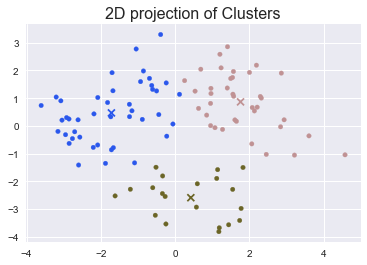

In [16]:
# generate some dummy data to make sure it roughly works
dummy = np.random.rand(100,10)
test = cluster_dataset(dummy,1.2)

#fit to data
test.train()


# predict some new data's cluster memberships
new_dummy = np.random.rand(4,10)
output = test.predict(new_dummy)

# visualize clusters
test.visualize()

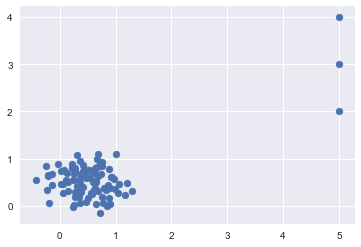

Lambda means clustering complete (lambda = 2). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.04598274771267962


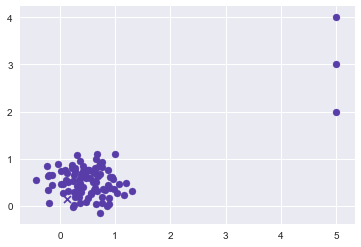

In [3]:
# another dummy example illustrating a failure due to ordering of points
if True:
    example = np.random.normal(0.5,0.3,[97,2])
    outliers = np.array([[5,4],[5,2],[5,3]])
    example = np.concatenate((example,outliers),0)

    test = cluster_dataset(example,2)
    plt.figure()
    plt.scatter(example[:,0],example[:,1])
    plt.show()

    test.train()
    n = np.max(test.cluster_memberships)+1
    colors = np.random.rand(n,3)
    plt.figure()
    for idx,item in enumerate(example):
        plt.scatter(item[0],item[1],color = colors[test.cluster_memberships[idx],:])
    for idx,item in enumerate(test.cluster_centroids):
        plt.scatter(item[0],item[1],marker = 'x', color = colors[idx,:])

Though a sufficiently large lambda value was used such that all 3 outlier points could conceivably be grouped into a single cluster, the order in which the points were input to the algorithm resulted in two clusters being assigned to this region of featurespace.

## 2. Dataset 1
Clustering is performed on the first dataset (high-dimensional guassian random distributions).

In [4]:
# parse first data file
with open("dataset_1.txt",'r') as f:
    all_lines = []
    for line in f:
        vals = []
        line = line.rstrip().split('   ')
        for item in line:
            if len(item) > 0:
                vals.append(int(item))
        row = np.array(vals)
        row = row[np.newaxis,:]
        all_lines.append(row)
    data1 = np.concatenate(all_lines, axis=0 )
print("Dataset 1 loaded. Size: {}".format(data1.shape))

Dataset 1 loaded. Size: (1024, 32)


In [5]:
def analyze_dataset(data,cutoff_ratio = 0.1,decay = 0.9):
    # generate results for a range of lambdas
    all_results = []

    cluster_data = cluster_dataset(data)
    lamb = cluster_data.lamb
    cluster_data.train()

    variance = cluster_data.intracluster_variance()
    num_clusters = np.max(cluster_data.cluster_memberships)+1

    all_results = np.array([[lamb,num_clusters,variance]])
    num_clusters = 1
    while num_clusters < len(data)*cutoff_ratio:
        lamb = decay*lamb
        cluster_data = cluster_dataset(data,lamb)
        cluster_data.train()

        variance = cluster_data.intracluster_variance()
        num_clusters = np.max(cluster_data.cluster_memberships)+1

        new_results = np.array([[lamb,num_clusters,variance]])
        all_results = np.concatenate((all_results,new_results),0)
   
    # find hinge point as max second derivative
    dx = all_results[1:,2] - all_results[:-1,2]
    ddx = dx[1:]-dx[:-1]
    opt_idx = np.argmax(ddx) +1
    lambda_opt = all_results[opt_idx,0]
    

    # plot results
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('lambda')
    ax1.set_ylabel('Intracluster Variance', color=color)
    ax1.plot(all_results[:,0],all_results[:,2], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax1.scatter(lambda_opt,all_results[opt_idx,2],color= color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('# clusters', color=color)  # we already handled the x-label with ax1
    ax2.plot(all_results[:,0],all_results[:,1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Effects of lambda parameter",fontsize= 16)
    plt.show()
    
    print("Optimal lambda: {} ".format(lambda_opt))
    print("Num clusters: {}".format(all_results[opt_idx,1]))
    print("Intracluster variance: {}".format(all_results[opt_idx,2]))
    return all_results, lambda_opt

Lambda means clustering complete (lambda = 2.819008209019544). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 2.53710738811759). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 2.283396649305831). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 2.055056984375248). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 1.8495512859377232). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 1.664596157343951). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 1.9765050241728668
Lambda means clustering complete (lambda = 1.4981365416095558). Took 3 itera

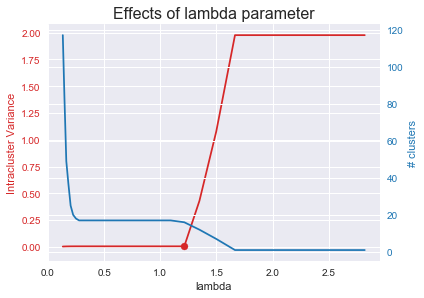

Optimal lambda: 1.21349059870374 
Num clusters: 16.0
Intracluster variance: 0.004932897675897625


In [6]:
# cluster dataset 1
result,lambda_opt = analyze_dataset(data1)

The optimal value of lambda is that for which subsequent increase results in a sharp increase in the intracluster variance (i.e. highly dissimilar data begin to be grouped in the same cluster). For the first dataset, the optimal value of lambda results in 16 clusters, which is close to what should be expected since the dataset was originally generated from 15 normal distributions. Thus, one distribution was sufficiently wide such that for this value of lambda, it was grouped into two separate clusters. This can be seen in the 2D projection of clusters below. A few possible explanations for this are:
- Reordering the data would result in a different number of clusters that more closely fits the 15 original Gaussian distributions. Say that the first two data examined by the clustering algorithm belong to the same Gaussian distribution but are on opposite extrema. Two clusters may be created, and once the centroids have been created within a distribution, there is no method in lambda-means clustering to merge these two centroids or get rid of one.  
- The optimal value for lambda was rather naively calculated by a rough estimate of the second derivative of intracluster variance. A more nuanced approach to its calculation may in fact determine an optimal lambda that yields 15 clusters.

Lambda means clustering complete (lambda = 1.21349059870374). Took 3 iterations and made 16.0 clusters.
Average intracluster variance: 0.004932897675897625


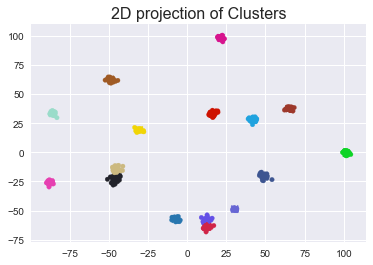

In [7]:
# visualize dataset 1 clusters
cluster_data = cluster_dataset(data1,lambda_opt)
cluster_data.train()
cluster_data.visualize()

## Dataset 2

In [8]:
# parse second data file
with open("dataset_2.txt",'r') as f:
    all_lines = []
    for line in f:
        vals = []
        line = line.rstrip().split(',')
        if len(line) == 39:
            for item in line[1:]:
                if item == '?':
                    vals.append(np.nan)
                else:
                    vals.append(float(item))
            row = np.array(vals)
            row = row[np.newaxis,:]
            all_lines.append(row)
    data2 = np.concatenate(all_lines, axis=0 )
    
# replace all ? values with average for that column
means = np.nanmean(data2,axis = 0)
for i in range(len(data2)):
    for j in range(len(data2[0])):
        if np.isnan(data2[i,j]):
            data2[i,j] = means[j]
print("Dataset 2 loaded. Size: {}".format(data2.shape))

Dataset 2 loaded. Size: (527, 38)


Lambda means clustering complete (lambda = 2.8127270304360823). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.672090678914278). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.538486144968564). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.4115618377201358). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.290983745834129). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.1764345585424225). Took 2 iterations and made 1.0 clusters.
Average intracluster variance: 0.3861732506782109
Lambda means clustering complete (lambda = 2.0676128306153014). Took 2 it

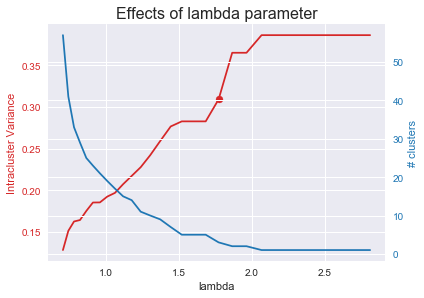

Optimal lambda: 1.7727195506487938 
Num clusters: 3.0
Intracluster variance: 0.30906705176861216


In [9]:
# cluster dataset 2
result,lambda_opt = analyze_dataset(data2,decay = 0.95)

For this dataset, the optimal value for lambda is less intuitively obvious, indicating that the data does not divide as cleanly into clusters as the first dataset. It could be argued that the dataset would be better represented by 2 clusters rather than 3, as is output using the optimal lambda value found by this analysis. Again, the clusters may also be susceptible to the ordering of the data points, and perhaps a more nuanced method for selecting lambda would yield a better result. However, the results are at least fairly informative for this dataset and clustering strategy.

Lambda means clustering complete (lambda = 1.7727195506487938). Took 22 iterations and made 3.0 clusters.
Average intracluster variance: 0.30906705176861216


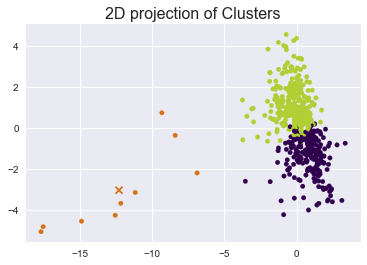

In [10]:
# visualize dataset 2 clusters
cluster_data = cluster_dataset(data2,lambda_opt)
cluster_data.train()
cluster_data.visualize()